In [1]:
!pip install openpyxl
!pip install japanize-matplotlib

Looking in indexes: https://ci-nexus.ai-knows.com/repository/pypi-group-aiq/simple
Looking in indexes: https://ci-nexus.ai-knows.com/repository/pypi-group-aiq/simple


In [2]:
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools
from aiq_strategy_robot.data.data_accessor import DAL
from aiq_strategy_robot.data.FACTSET import load_factset_fundamental_estimates

if '../..' not in sys.path:
    sys.path.append('../..')
from libs.dataset import aiq_pos_csmr_goods as sc_goods
from libs.dataset import common as sc_common
from libs.path import DEFAULT_DIR
import japanize_matplotlib

## データ読み込み

In [3]:
sdh = DAL()

# POSデータ
data_id_alt = sc_goods.register_csmr_goods_data(sdh, data_dir=DEFAULT_DIR)
alt_W_id = sdh.transform.raw(data_id=data_id_alt).variable_ids[0]

# sales(YoY)データ
data_id_funda = sc_common.register_fundamental(sdh)
funda_Q_id = sdh.transform.raw(data_id=data_id_funda).variable_ids[0]

#### 売上高のコンセンサス予想を準備
- TICKER
- fiscal_period_end_date：四半期末日
- consensus_start_date  ：コンセンサスが有効になった日
- consensus_end_date    ：コンセンサスが無効になった日
- consensus (FE_MEDIAN) ：コンセンサス（アナリスト予測の中央値）

In [4]:
# コンセンサス予想
## 締日時点のコンセンサス予想を使用
h1 = sdh.load('FACTSET', data_type='symbol_lookup',
              ticker=list(map(lambda x: f"{x}-JP", sdh.extract_definition.loc[data_id_alt, 'tickers'])),
              currency_code='JPY', exchange_code='TKS', pick_only_primary=True)
comp = h1.retrieve(transformed=False)
h2 = load_factset_fundamental_estimates(h1, symbols=list(comp['FSYM_ID']),
                                        package="BASIC", fields="SALES", freq=3)
consensus = h2.retrieve()
consensus = consensus.merge(comp, how='left', left_on='SYMBOL', right_on='FSYM_ID')
consensus['TICKER'] = consensus['TICKER'].map(lambda x: x.split('-')[0])
consensus = consensus.set_index(['TICKER', 'fiscal_period_end_date', 'consensus_start_date', 'consensus_end_date']).sort_index()
consensus = consensus[consensus['FE_MEDIAN'] > 0]
cons = consensus[consensus.index.get_level_values('consensus_start_date') <= consensus.index.get_level_values('fiscal_period_end_date')].groupby(
    ['TICKER', 'fiscal_period_end_date']).tail(1)[['FE_MEDIAN']].reset_index(['consensus_start_date', 'consensus_end_date']).rename(columns={'FE_MEDIAN': 'consensus'})



In [5]:
#  不要なカラムを削除
# - consensus_start_date：コンセンサスが使えるように有効になった日
# - consensus_end_date：無効になった日

cons = cons.drop(columns=['consensus_start_date', 'consensus_end_date'])
cons.head()

consensus
TICKER fiscal_period_end_date           
1301   2017-06-30                58100.0
       2017-09-30                63300.0
       2017-12-31                74650.0
       2018-03-31                56677.0
       2018-06-30                58800.0

In [6]:
# 宇野さんに確認
## →コンセンサスのYOY作成に必要。ユーザーにはあらかじめデータのセットアップを通知

In [7]:
HAS_MY_SALES = True

# 売上(実数値)の実績
sales = pd.read_parquet('sales.parquet').sort_index()
sales.index.names = ['TICKER', 'DATETIME']
sales_YoY = sales.groupby('TICKER', group_keys=False)['sales'].apply(lambda x: np.log(x / x.shift(4)))
sales.head()

first_announcement_datetime    sales
TICKER DATETIME                                       
1301   2008-03-31         2008-05-13 15:00:00  31689.0
       2008-06-30         2008-07-29 15:00:00  36678.0
       2008-09-30         2008-10-29 15:00:00  36966.0
       2008-12-31         2009-01-29 15:00:00  41851.0
       2009-03-31         2009-05-14 15:00:00  32059.0

In [8]:
# ↓s3におく

In [9]:
# POSのシェア率(時系列)
share_ts = pd.read_excel('20241003_pos_csmr_goods_plus_sales_share_ts.xlsx')
share_ts['seccode'] = share_ts['seccode'].map(str)
share_ts['datetime'] = pd.to_datetime(share_ts['datetime'])
share_ts = share_ts.set_index(['seccode', 'datetime']).sort_index()
share_ts.head()




count      mean       std    median
seccode datetime                                       
1301    2018-06-30      6  0.042412  0.005532  0.042914
        2018-09-30      7  0.042328  0.005055  0.041819
        2018-12-31      8  0.041800  0.004912  0.041302
        2019-03-31      9  0.042866  0.005598  0.041819
        2019-06-30     10  0.043762  0.005990  0.043431

## 最適な前処理パラメータの探索

In [10]:
lags = [-3, -2, -1, 0]
diffs = [True, False]

In [11]:
correlations = {}
pos_data = {}
for lag, diff in tqdm(itertools.product(lags, diffs), total=len(lags)*len(diffs)):
    
    alt_shift_id = alt_W_id
    if lag != 0:
        alt_shift_id = sdh.transform.shift(fields=alt_shift_id, periods=lag).variable_ids[0]
    
    alt_Q_shift_id = sdh.transform.resample_by(fields=alt_shift_id, label=funda_Q_id, func='mean').variable_ids[0]
    
    alt_id = sdh.transform.log_diff(fields=alt_Q_shift_id, periods=4).variable_ids
    sales_id = funda_Q_id

    if diff:
        alt_id = sdh.transform.diff(fields=alt_id, periods=1).variable_ids
        sales_id = sdh.transform.diff(fields=sales_id, periods=1).variable_ids

    
    data = pd.concat({
        'y': sdh.get_variables(sales_id).iloc[:, 0], 
        'X':sdh.get_variables(alt_id).iloc[:, 0]}, axis=1
    ).dropna()

    
    pos_data[lag, diff] = data
    for ticker, _ in tqdm(data.groupby('TICKER'), leave=False):
        for d in data.xs(ticker).expanding():
            if len(d.dropna()) < 10:
                continue
            mdl = sm.OLS(d['y'], sm.add_constant(d['X'].values), missing="drop").fit()
            correlations[ticker, d.index[-1], lag, diff] = { "t_val": mdl.tvalues['x1'] }
            
correlations = pd.DataFrame(correlations).T
correlations.index.names = ['TICKER', 'datetime', 'lag', 'diff1']
pos_data = pd.concat(pos_data)
pos_data.index.names = ['lag', 'diff', 'TICKER', 'DATETIME']

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

In [314]:
best_correlations = correlations.sort_values('t_val').groupby(['TICKER', 'datetime']).tail(1).reset_index(['lag', 'diff1']).sort_index()

## 予測用データの作成

In [321]:
def set_data(dic, d):

    d = d.dropna().copy()
    if len(d) <= 20:
        return
    d.index.names = ['DATETIME']
    d['PRED_DATETIME'] = datetime
    d['TICKER'] = ticker
    d = d.reset_index().set_index(['PRED_DATETIME', 'TICKER', 'DATETIME'])
    dic.append(d)


dataset_with_consensus = []
dataset_without_consensus = []
for (ticker, until), setting in tqdm(best_correlations.iloc[:].iterrows(), total=len(best_correlations.iloc[:])):
    lag, diff1 = setting['lag'], setting['diff1']
    d = pos_data.xs(lag).xs(diff1).xs(ticker).loc[:until].copy()
    try:
        target = pos_data.xs(lag).xs(diff1).xs(ticker).loc[until:].iloc[1]
    except:
        continue
    datetime = target.name
    best_correlations.loc[(ticker, until), 'PRED_DATETIME'] = datetime
    
    YoY0 = sales_YoY.xs(ticker).xs(datetime)
    YoY1 = pos_data.xs(lag).xs(False).xs(ticker).xs(datetime)['y']
    if abs(YoY0 - YoY1) > 1e-4: # 別途用意した売上実績から計算したYoYと乖離がある場合は除外(売上集計の定義が変化?)
        continue
    
    d = pd.concat([d, target.to_frame().T])
    if (ticker, datetime) in cons.index and HAS_MY_SALES:
        con = cons.xs(ticker)[['consensus']]
        con['pre'] = sales.xs(ticker).shift(4)['sales']
        con['y'] = np.log(con['consensus'] / con['pre'])
        if diff1:
            con['y'] = con['y'].diff()
        d['con_y'] = con['y']
        
        set_data(dataset_with_consensus, d)   
    else:
        set_data(dataset_without_consensus, d)


dfbest_correlations = best_correlations.reset_index().set_index(['TICKER', 'PRED_DATETIME'])
dfdataset_with_cons = pd.concat(dataset_with_consensus)
dfdataset_without_cons = pd.concat(dataset_without_consensus)

display(dfbest_correlations.tail())
display(dfpred_with_cons.tail())
display(dfpred_without_cons.tail())

  0%|          | 0/10890 [00:00<?, ?it/s]

datetime  lag  diff1     t_val
TICKER PRED_DATETIME                                 
9997   2023-06-30    2023-03-31   -3   True  2.348745
       2023-09-30    2023-06-30   -3   True  2.423474
       2023-12-31    2023-09-30   -3   True  2.452933
       2024-03-31    2023-12-31   -3   True  2.418634
       NaT           2024-03-31   -3   True  2.370913

y         X     con_y
PRED_DATETIME TICKER DATETIME                                
2024-03-31    9997   2022-12-31  0.015065 -0.845644  0.081961
                     2023-03-31  0.026520  0.629671  0.082671
                     2023-09-30  0.006300 -0.032195 -0.093056
                     2023-12-31 -0.000614  0.687694  0.006470
                     2024-03-31  0.026541 -0.367042 -0.030684

y         X
PRED_DATETIME TICKER DATETIME                      
2023-06-30    9997   2022-06-30 -0.081314  0.135409
                     2022-09-30  0.064297  0.528664
                     2022-12-31  0.015065 -0.845644
                     2023-03-31  0.026520  0.629671
                     2023-06-30 -0.038482 -0.384819

## 予測処理

In [323]:
def predict(dataset: pd.DataFrame, dfbest_corr: pd.DataFrame, X: list, y: str):

    prediction = {}
    for (ticker, datetime), df in tqdm(dataset.groupby(['TICKER', 'PRED_DATETIME'])):
        train_x = df[df.index.get_level_values('DATETIME') < datetime][X]
        train_y = df[df.index.get_level_values('DATETIME') < datetime][y]
        test_x = df[df.index.get_level_values('DATETIME') == datetime][X].iloc[0]
        until = train_x.index.get_level_values('DATETIME').max()
    
        params = dfbest_corr.xs(ticker).xs(datetime)
        lag, diff1, t_val, until = params.lag, params.diff1, params.t_val, params['datetime']
    
        mdl = sm.OLS(train_y, sm.add_constant(train_x.values), missing="drop").fit()
        y_predict = mdl.predict([1, *[test_x[x] for x in X]])
        
        ys = pos_data.xs(lag).xs(ticker, level='TICKER')[y].unstack('diff').loc[:datetime].copy()
        try:
            sales_pre = sales.xs(ticker).loc[:datetime, 'sales'].iloc[-5]
            sales_actual = sales.xs(ticker).xs(datetime)['sales'] # np.exp(ys).loc[datetime, False] * sales_pre
            sales_extrapolation = np.exp(ys[False].iloc[-2]) * sales_pre # 前期の実績成長率(YoY) * 前年同期の売上
        except:
            continue
        
        ys.loc[datetime, diff1] = y_predict
        ys.loc[datetime, not diff1] = np.nan
        if diff1:
            ys.loc[datetime, False] = ys.loc[until, False] + ys.loc[datetime, True]
        sales_predict = np.exp(ys).loc[datetime, False] * sales_pre
        prediction[ticker, datetime] = {
            'actual': sales_actual, 
            'predict': sales_predict,
            "t_val": t_val,
            "extrapolation": sales_extrapolation
        }

    prediction = pd.DataFrame(prediction).T
    prediction.index.names = ['TICKER', 'datetime']

    return prediction

### コンセンサス存在の銘柄に対する予測
コンセンサスとPOSによる線形重回帰

In [324]:
prediction_with_consensus = predict(dfdataset_with_cons, dfbest_correlations, ['X', 'con_y'], 'y')

  0%|          | 0/2606 [00:00<?, ?it/s]

In [325]:
prediction_with_consensus['consensus'] = cons['consensus']

In [326]:
prediction_with_consensus['Predict'] = (prediction_with_consensus['predict'] - prediction_with_consensus['actual']) / prediction_with_consensus['actual']
prediction_with_consensus['Consensus'] = (prediction_with_consensus['consensus'] - prediction_with_consensus['actual']) / prediction_with_consensus['actual']
prediction_with_consensus['win'] = \
(prediction_with_consensus['predict'] - prediction_with_consensus['actual']).abs() < (prediction_with_consensus['consensus']  - prediction_with_consensus['actual']).abs()

In [327]:
prediction_with_consensus['win_rate_until'] = prediction_with_consensus['win'].sort_index().groupby('TICKER', group_keys=False).apply(lambda x: x.expanding().mean().shift(1))
pre_win = prediction_with_consensus[prediction_with_consensus['win_rate_until']>0.5].copy()
np.sqrt( (pre_win[['Predict', 'Consensus']]**2).mean() ).to_frame('RMSPE')

,RMSPE
Predict,0.111908
Consensus,0.149455


<AxesSubplot: title={'center': '0'}, xlabel='level_2'>

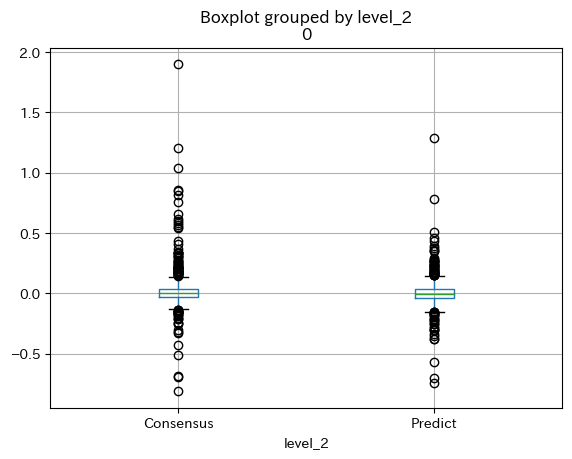

In [197]:
pre_win[['Predict', 'Consensus']].stack().reset_index(level=-1).boxplot(0, by='level_2')

In [198]:
matrix = ((pre_win['actual'] - pre_win['consensus']).map(np.sign) == (pre_win['predict'] - pre_win['consensus']).map(np.sign)).value_counts()
display(matrix.to_frame('direction_is_coincident'))
print(f'rate = {matrix[True] / sum(matrix)}')

,direction_is_coincident
True,560
False,306


rate = 0.6466512702078522


Text(0.5, 1.0, 'コンセンサス予想 : 前年同期より増加\nPOSによる予想 : 前年同期より減少')

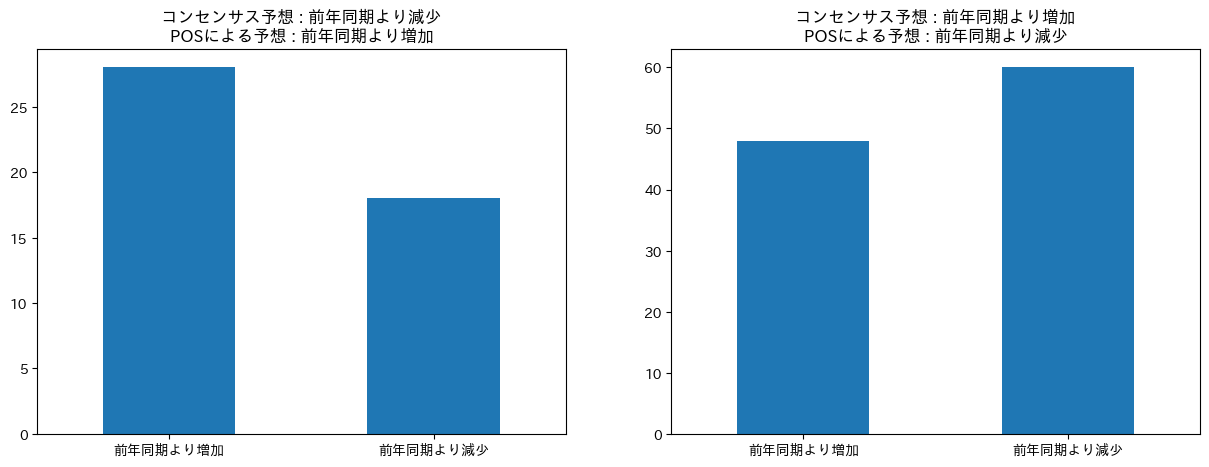

In [199]:
pre_win['actual_pre'] = sales.sort_index()['sales'].groupby('TICKER', group_keys=False).apply(lambda x: x.shift(4))
pre_win['actual_YoY'] = np.log(pre_win['actual']) - np.log(pre_win['actual_pre'])
pre_win['predict_YoY'] = np.log(pre_win['predict']) - np.log(pre_win['actual_pre'])
pre_win['consensus_YoY'] = np.log(pre_win['consensus']) - np.log(pre_win['actual_pre'])

_, axes = plt.subplots(1, 2, figsize=(15,5))
pre_win[(pre_win['consensus_YoY'] < 0) & (pre_win['predict_YoY'] > 0) ]['actual_YoY'].map(np.sign).map({1:'前年同期より増加', -1:'前年同期より減少'}).value_counts().sort_index().plot.bar(ax=axes[0], rot=0)
axes[0].set_title('コンセンサス予想 : 前年同期より減少\nPOSによる予想 : 前年同期より増加')
pre_win[(pre_win['consensus_YoY'] > 0) & (pre_win['predict_YoY'] < 0) ]['actual_YoY'].map(np.sign).map({1:'前年同期より増加', -1:'前年同期より減少'}).value_counts().sort_index().plot.bar(ax=axes[1], rot=0)
axes[1].set_title('コンセンサス予想 : 前年同期より増加\nPOSによる予想 : 前年同期より減少')

In [200]:
examples = pd.concat({'rate': prediction_with_consensus.groupby('TICKER')['win'].mean().sort_values(), 'count': prediction_with_consensus.groupby('TICKER')['win'].size()}, axis=1)
examples[examples['count']>=40].sort_values('rate').tail()

,rate,count
TICKER,,
6702,0.475000,40
3402,0.487805,41
4901,0.512195,41
8113,0.525000,40
4188,0.625000,40


Text(0, 0.5, 'YoY(logdiff)')

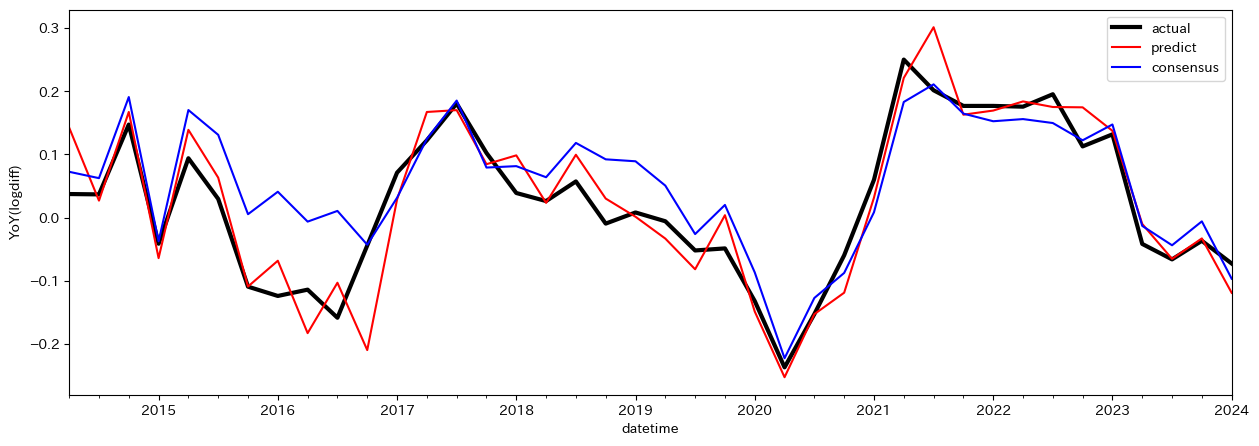

In [202]:
ticker = '4188'
sample = prediction_with_consensus.xs(ticker)[['actual', 'predict', 'consensus']].copy()
sample['pre'] = sales.xs(ticker).sort_index().shift(4)['sales']
sample[['pos', 'y']] = pos_data.xs(0).xs(False).xs(ticker)[['X', 'y']]

ax = (np.log(sample['actual']) - np.log(sample['pre'])).plot(color='black', linewidth=3, figsize=(15,5), label='actual')
(np.log(sample['predict']) - np.log(sample['pre'])).plot(color='red', ax=ax, label='predict')
(np.log(sample['consensus']) - np.log(sample['pre'])).plot(color='blue', ax=ax, label='consensus')
# sample['y'].plot(ax=ax, label='y', linestyle=':')
# sample['pos'].plot(ax=ax, label='POS', linestyle=':')
ax.legend()
plt.ylabel('YoY(logdiff)')

### コンセンサス不在の銘柄に対する予測
POSによる線形単回帰

In [303]:
prediction_without_consensus = predict(dfdataset_without_cons, dfbest_correlations, ['X'], 'y')

  0%|          | 0/4093 [00:00<?, ?it/s]

In [304]:

prediction_without_consensus['Predict'] = (prediction_without_consensus['predict'] - prediction_without_consensus['actual']) / prediction_without_consensus['actual']
prediction_without_consensus['Extrapolation'] = (prediction_without_consensus['extrapolation'] - prediction_without_consensus['actual']) / prediction_without_consensus['actual'] 
prediction_without_consensus['share'] = share_ts.groupby('seccode', group_keys=False)['mean'].apply(lambda x: x.shift(1)).reindex(prediction_without_consensus.index)
prediction_without_consensus['Extrapolation'] = (prediction_without_consensus['extrapolation'] - prediction_without_consensus['actual']) / prediction_without_consensus['actual'] 

In [305]:
good = prediction_without_consensus[(prediction_without_consensus['share']>0.05)&(prediction_without_consensus['t_val']>0)].copy()

In [306]:
np.sqrt(((good[['Predict', 'Extrapolation']])**2).mean()).to_frame('RMSPE')

,RMSPE
Predict,0.122343
Extrapolation,0.143605


宇野さんに確認：
実績に戻す必要について


In [ ]:
## backtestしたい
- prediction
- コンセンサス
- extrapolation